In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm import tqdm
from grid_world import GridWorld
import draw
import utils


In [2]:
from math import gamma


class ReinForce:
    def __init__(self, state_dim, hidden_dim, action_dim, env_row, env_col, learning_rate, gamma) -> None:
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.action_dim = action_dim
        self.env_row = env_row
        self.env_col = env_col
        self.learning_rate = learning_rate
        self.gamma = gamma

        self.policy_tabular = np.full((env_row * env_col, action_dim), 1 / action_dim)
        self.epsilon = 1

    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            x, y = state
            action_prob = self.policy_tabular[x * self.env_col + y]
            action = np.random.choice(self.action_dim, p=action_prob)
        return action

    def update(self, transition_dict):
        rewards_list = transition_dict["rewards"]
        state_list = transition_dict["states"]
        action_list = transition_dict["actions"]

        losses = [[[] for j in range(self.action_dim)] for i in range(self.env_row * self.env_col)]

        G = 0
        for i in reversed(range(len(rewards_list))):
            reward = rewards_list[i]
            state = state_list[i]
            action = action_list[i]
            x, y = state

            grad = 1 / self.policy_tabular[x * 5 + y][action]
            grad = max(0, grad)
            grad = min(10, grad)

            G = G * self.gamma + reward
            loss = grad * G
            losses[x * self.env_col + y][action].append(loss)

        loss_mean = np.array(
            [
                [
                    sum(losses[i][j]) / len(losses[i][j])
                    if len(losses[i][j]) != 0
                    else 0
                    for j in range(self.action_dim)
                ]
                for i in range(self.env_col * self.env_row)
            ]
        )
        loss_sum = np.array(
            [
                [
                    sum(losses[i][j]) if len(losses[i][j]) != 0 else 0
                    for j in range(self.action_dim)
                ]
                for i in range(self.env_col * self.env_row)
            ]
        )
        loss = loss_sum
        self.loss = loss / 10
        self.policy_tabular += loss * self.learning_rate

        self.policy_tabular = np.clip(self.policy_tabular, 0.001, 1)
        self.policy_tabular = self.policy_tabular/self.policy_tabular.sum(axis=1)[:,None]
        self.policy_tabular = np.nan_to_num(self.policy_tabular, nan=1 / self.action_dim)


In [3]:
def train(hyperparameters, img_path):
    rows = 5
    cols = 5

    forbidden_score = hyperparameters["forbidden_score"]
    terminal_score = hyperparameters["terminal_score"]
    hit_wall_score = hyperparameters["hit_wall_score"]
    move_score = hyperparameters["move_score"]
    start_state = hyperparameters["start_state"]
    action_space = hyperparameters["action_space"]
    learning_rate = hyperparameters["learning_rate"]
    num_episodes = hyperparameters["num_episodes"]
    hidden_dim = hyperparameters["hidden_dim"]
    gamma = hyperparameters["gamma"]

    env = GridWorld(
        init_state=start_state,
        move_score=move_score,
        action_space=action_space,
        forbidden_score=forbidden_score,
        terminal_score=terminal_score,
        hit_wall_score=hit_wall_score,
        desc=[".....", ".##..", "..#..", ".#T#.", ".#..."],
    )

    agent = ReinForce(
        state_dim=env.get_observation_space(),
        hidden_dim=hidden_dim,
        action_dim=env.get_action_space(),
        env_row=env.rows,
        env_col=env.cols,
        learning_rate=learning_rate,
        gamma=gamma,
    )

    return_list = []

    epsilon = 1
    final_epsilon = 0.15
    for i in tqdm(range(num_episodes)):  # 10000
        if epsilon > final_epsilon:
            epsilon -= hyperparameters["gamma_minus_each_episodes"]
        else:
            epsilon = final_epsilon
        agent.epsilon = epsilon

        episode_return = 0
        transition_dict = {
            "states": [],
            "actions": [],
            "next_states": [],
            "rewards": [],
            "dones": [],
        }
        state = env.reset()
        done = False
        cnt = 0
        while not done:
            cnt = cnt + 1
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            transition_dict["states"].append(state)
            transition_dict["actions"].append(action)
            transition_dict["next_states"].append(next_state)
            transition_dict["rewards"].append(reward)
            transition_dict["dones"].append(done)
            state = next_state
            episode_return += reward

            # if episode_return <= forbiddenAreaScore*2:
            #     break  #如果被惩罚了两次，那么就跳出迭代，开始扣分！！

            if cnt > hyperparameters["exploring_step"]:
                break

        return_list.append(episode_return)
        pre_frame_probabilities = agent.policy_tabular.copy()

        agent.update(transition_dict)

        now_frame_probabilities = agent.policy_tabular

        if i % 20000 == 0:
            draw.plot_policy(
                pre_frame_probabilities,
                now_frame_probabilities,
                agent.loss,
                transition_dict["states"],
                env.get_map_description(),
                img_path,
            )


experiments/Penalty-60_Score100_State(0~24)/Penalty-60_Score100_State10


  0%|          | 0/200000 [00:00<?, ?it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


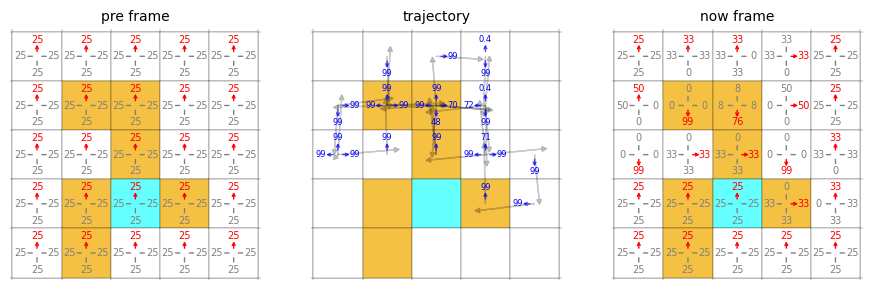

 10%|▉         | 19875/200000 [00:05<00:42, 4235.74it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


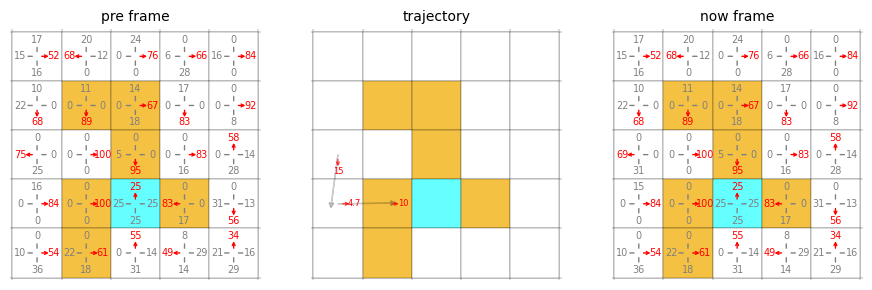

 20%|█▉        | 39805/200000 [00:11<00:34, 4626.68it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


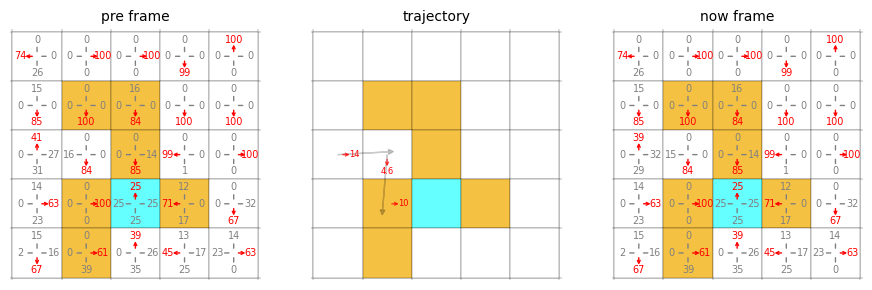

 30%|██▉       | 59877/200000 [00:16<00:30, 4664.04it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


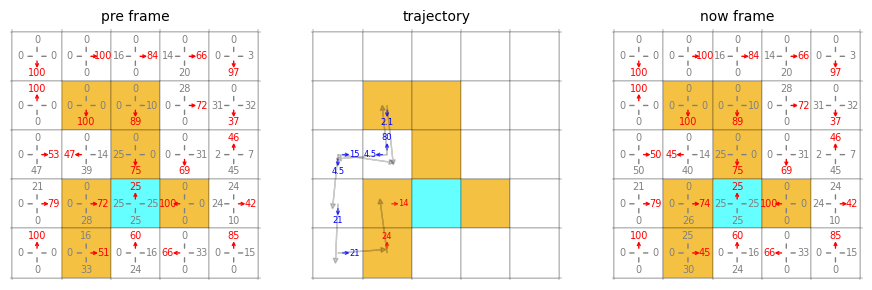

 40%|███▉      | 79728/200000 [00:21<00:22, 5452.33it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


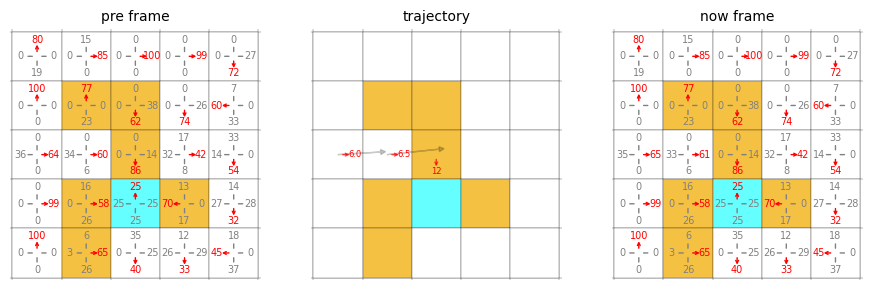

 50%|████▉     | 99785/200000 [00:26<00:19, 5030.88it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


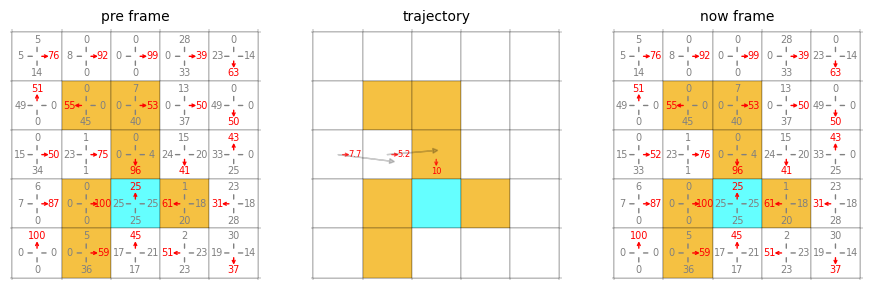

 60%|█████▉    | 119581/200000 [00:31<00:15, 5170.79it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


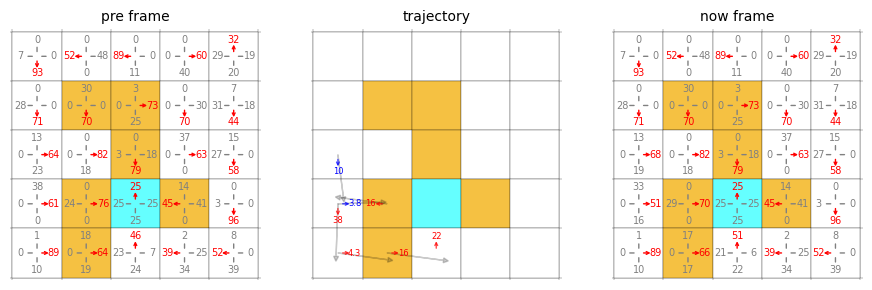

 70%|██████▉   | 139928/200000 [00:35<00:10, 5509.54it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


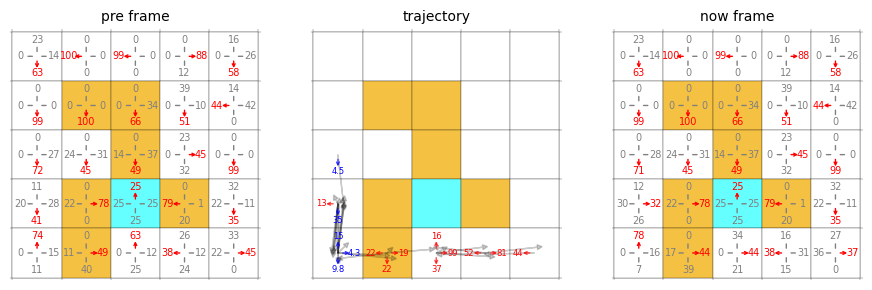

 80%|███████▉  | 159611/200000 [00:40<00:07, 5165.38it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


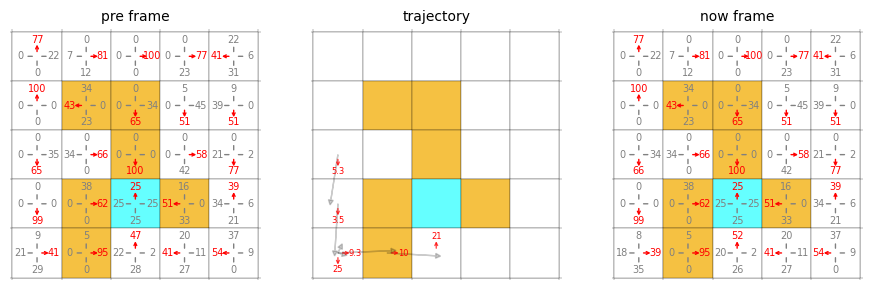

 90%|████████▉ | 179545/200000 [00:45<00:05, 3886.00it/s]findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.


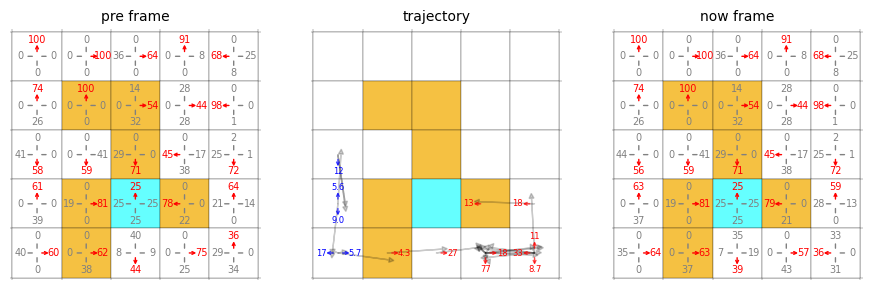

100%|██████████| 200000/200000 [00:51<00:00, 3921.34it/s]


In [4]:
hyperparameters = {
    "forbidden_score": -60,  # 踩陷阱和碰壁的惩罚
    "hit_wall_score": -10,
    "terminal_score": 100,  # 奖励
    "move_score": 0,  # 移动惩罚
    "action_space": 4,
    "learning_rate": 0.0005,
    "hidden_dim": 512,
    "gamma": 0.99,  # 折扣因子
    "num_episodes": 200000,  # 训练轮次，每次训练epsilon -= gamma_minus_each_episodes
    "start_state": 10,
    "gamma_minus_each_episodes": 0.00001,
    "exploring_step": 30,
}

start_state = hyperparameters["start_state"]

# 创建 images 文件夹（如果不存在）
experiment_name = f"Penalty{hyperparameters['forbidden_score']}_Score{hyperparameters['terminal_score']}_State"
output_dir = f"experiments/{experiment_name}(0~24)/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 图片文件路径

img_name = f"{experiment_name}{start_state}"
img_path = os.path.join(output_dir, img_name)
xlsx_path = os.path.join(output_dir, experiment_name + ".xlsx")
print(img_path)
train(hyperparameters, img_path)

utils.write_excel(
    hyperparameters,
    img_path + ".png",
    bias=start_state,
    xlsx_path=xlsx_path,
    highlights=["start_state"],
)
